In [1]:
import os
import sys
import random
import warnings
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import *
from skimage.transform import resize
from skimage.morphology import label

import keras
from keras import optimizers
from keras.models import Model, load_model
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 400
IMG_HEIGHT = 400
IMG_CHANNELS = 3
TRAIN_PATH = 'datasets/training/images'
TEST_PATH = 'datasets/training/groundtruth'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Get train and test IDs
train_ids = glob.glob(TRAIN_PATH+"/satImage_*.png")
test_ids = glob.glob(TEST_PATH+"/satImage_*.png")

In [3]:
data_x = []
data_y = []

for path in train_ids:
    data_x.append(imread(path))

for path in test_ids:
    data_y.append(imread(path))

In [4]:
from augmentation import*

data_x_aug, data_y_aug = augment_data(data_x, data_y)


In [5]:
data_x_aug = np.array(data_x_aug)/255.0
data_y_show=np.array(data_y_aug)/255.0
data_y_aug = np.array(data_y_aug).reshape((-1, 400, 400, 1))/255.0

In [6]:
data_x_aug.shape, data_y_aug.shape

((4800, 400, 400, 3), (4800, 400, 400, 1))

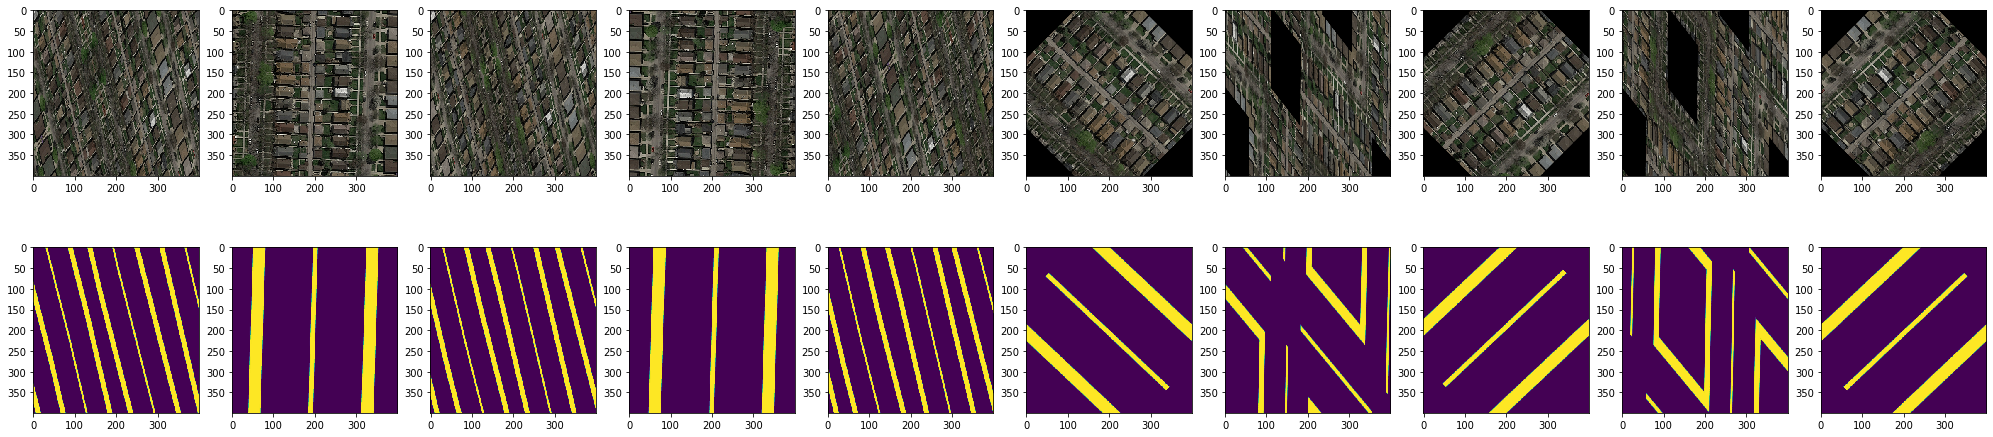

In [7]:
i = 1
j = 1
fig, axs = plt.subplots(2, 10, figsize=(35,8))
for i in range(10):
    axs[0, i].imshow(data_x_aug[j+i])
    axs[1, i].imshow(data_y_show[j+i])

In [8]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
def unet(input_size = (400,400,3), s=[2, 4, 8]):
    inputs = Input(input_size)
    in_ = inputs
    layers = []
    for i in s:
        conv = Conv2D(i, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(in_)
        conv = Conv2D(i, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
        layers.append(conv)
        in_ = MaxPooling2D(pool_size=(2, 2))(conv)
    
    conv = Conv2D(2*s[-1], 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(in_)
    conv = Conv2D(2*s[-1], 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    in_ = Dropout(0.2)(conv)

    for n, i in enumerate(s[::-1]):
        conv = Conv2D(i, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(in_))
        conv = concatenate([layers[-1-n], conv], axis = 3)
        in_ = Conv2D(i, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
        
    conv = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(in_)
    outputs = Conv2D(1, 1, activation = 'sigmoid')(conv)

    model = Model(input = inputs, output = outputs)

    model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [f1_m, 'accuracy'])
    
    model.summary()

    return model

In [13]:
my_model = unet()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 400, 400, 2)  56          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 400, 400, 2)  38          conv2d_17[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 200, 200, 2)  0           conv2d_18[0][0]                  
____________________________________________________________________________________________

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [23]:
my_model.fit(x=data_x_aug, y=data_y_aug, batch_size=8, epochs=1, validation_split=0.15, shuffle=True)


Train on 4080 samples, validate on 720 samples
Epoch 1/1
  24/4080 [..............................] - ETA: 1:45:22 - loss: 0.2167 - f1_m: 0.7107 - accuracy: 0.7652

KeyboardInterrupt: 

In [33]:
pred = my_model.predict(data_x_aug[0:3])


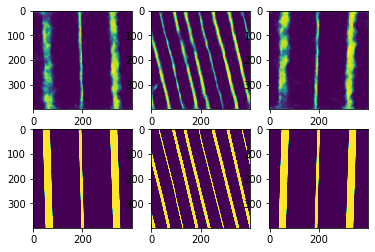

In [34]:
i = 0
fig, axs = plt.subplots(2, 3)
axs[0, 0].imshow(pred[i,:,:,0])
axs[1, 0].imshow(data_y_aug[i,:,:,0])
axs[0, 1].imshow(pred[i+1,:,:,0])
axs[1, 1].imshow(data_y_aug[i+1,:,:,0])
axs[0, 2].imshow(pred[i+2,:,:,0])
axs[1, 2].imshow(data_y_aug[i+2,:,:,0])



In [20]:
def save_model(model_name, model):
    model_json = model.to_json()
    with open(model_name+'.json', "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name+'.h5')
    print("Saved model to disk")
model_name='models/model2'   
save_model(model_name, my_model)

Saved model to disk


In [22]:
from keras.models import model_from_json
def load_model(model_name):
    json_file = open(model_name+'.json', 'r')
    model_json = json_file.read()
    json_file.close()
    model = model_from_json(model_json)
    model.load_weights(model_name+'.h5')
    print("Loaded model from disk")
    return model
model_name='models/model_45degrees_20_40_80param_epoch11'   
my_model=load_model(model_name)
my_model.compile(optimizer = optimizers.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = [f1_m, 'accuracy'])    
my_model.summary()



Loaded model from disk
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 20) 560         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 400, 400, 20) 3620        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 200, 200, 20) 0           conv2d_2[0][0]                   
_____________________________________________________________________